# Báo cáo Khoa học - Đã tối ưu tốc độ
---

In [1]:
import os, hashlib, shutil, random, cv2, torch, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, mean_squared_error, r2_score
from tqdm import tqdm

# Cấu hình hệ thống
BASE_PATH = r'd:\HUTECH\AI\DeepLearning\DAHS\MangoLeaf'
DST_PATH = os.path.join(BASE_PATH, 'dataset_scientific_split')
RESULT_PATH = os.path.join(BASE_PATH, 'Result')
IMG_SIZE = 224; BATCH_SIZE = 32; EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(os.path.join(DST_PATH, 'train'), transform=transform)
val_set = datasets.ImageFolder(os.path.join(DST_PATH, 'val'), transform=transform)
test_set = datasets.ImageFolder(os.path.join(DST_PATH, 'test'), transform=transform)

# Tối ưu nạp dữ liệu
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

CLASS_NAMES = train_set.classes; NUM_CLASSES = len(CLASS_NAMES)

def get_model(name, num_classes):
    if name == 'SimpleCNN': m = nn.Sequential(nn.Conv2d(3,32,3,1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(32*111*111, num_classes))
    elif name == 'AlexNet': m = models.alexnet(weights='DEFAULT'); m.classifier[6] = nn.Linear(4096, num_classes)
    elif name == 'MobileNetV2': m = models.mobilenet_v2(weights='DEFAULT'); m.classifier[1] = nn.Linear(1280, num_classes)
    elif name == 'MobileNetV3': m = models.mobilenet_v3_small(weights='DEFAULT'); m.classifier[3] = nn.Linear(1024, num_classes)
    elif name == 'ResNet18': m = models.resnet18(weights='DEFAULT'); m.fc = nn.Linear(512, num_classes)
    elif name == 'ResNet50': m = models.resnet50(weights='DEFAULT'); m.fc = nn.Linear(2048, num_classes)
    elif name == 'ShuffleNetV2': m = models.shufflenet_v2_x1_0(weights='DEFAULT'); m.fc = nn.Linear(1024, num_classes)
    elif name == 'DenseNet121': m = models.densenet121(weights='DEFAULT'); m.classifier = nn.Linear(1024, num_classes)
    elif name == 'EfficientNetV2': m = models.efficientnet_v2_s(weights='DEFAULT'); m.classifier[1] = nn.Linear(1280, num_classes)
    elif name == 'ConvNeXt_Tiny': m = models.convnext_tiny(weights='DEFAULT'); m.classifier[2] = nn.Linear(768, num_classes)
    return m.to(DEVICE)


### Mô hình: SimpleCNN
**Mô tả:** Baseline 2 lớp Conv.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: SimpleCNN ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\4034973385.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP
Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\4034973385.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\4034973385.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]


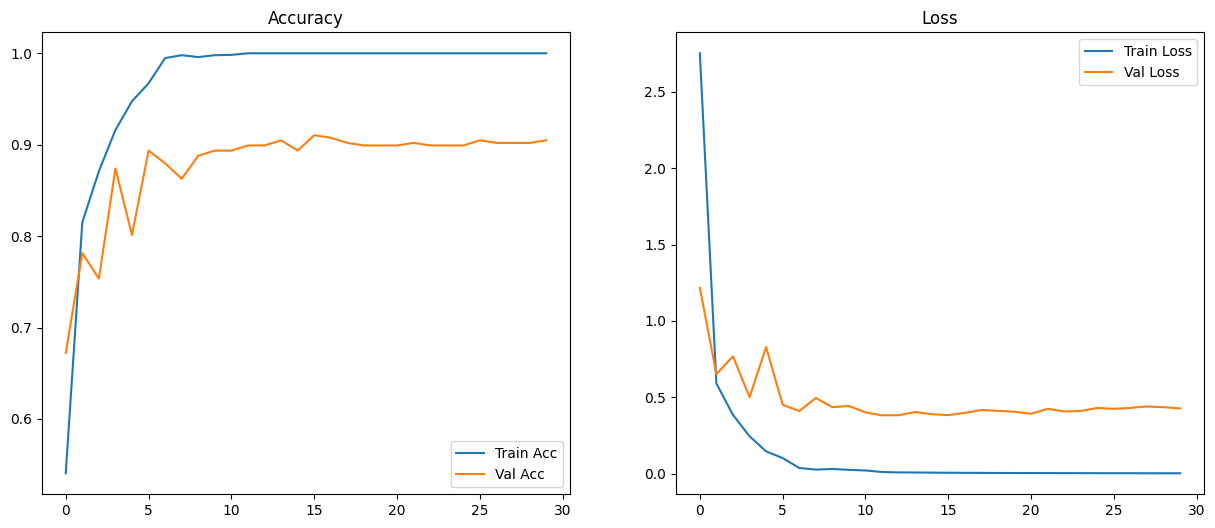

Done SimpleCNN: Accuracy=0.8972


In [2]:
## Huấn luyện TỐI ƯU mô hình: SimpleCNN
m_name = 'SimpleCNN'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: AlexNet
**Mô tả:** Cổ điển mạnh mẽ.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: AlexNet ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\756986753.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP
Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\756986753.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\756986753.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


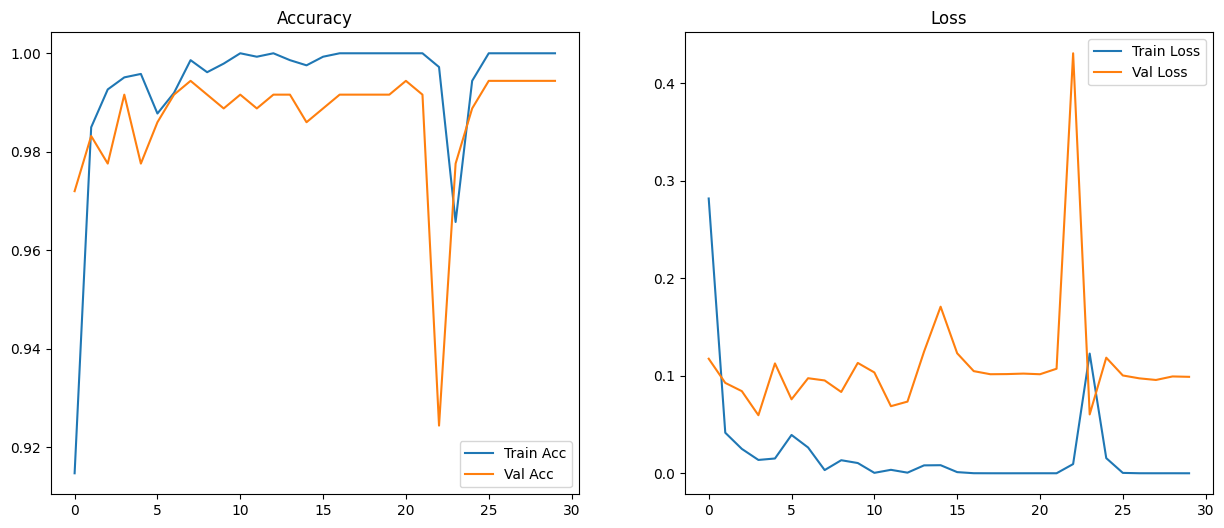

Done AlexNet: Accuracy=0.9944


In [3]:
## Huấn luyện TỐI ƯU mô hình: AlexNet
m_name = 'AlexNet'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: MobileNetV2
**Mô tả:** Tối ưu di động.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\1058085520.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP


--- Đang khởi tạo mô hình: MobileNetV2 ---


Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\1058085520.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\1058085520.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


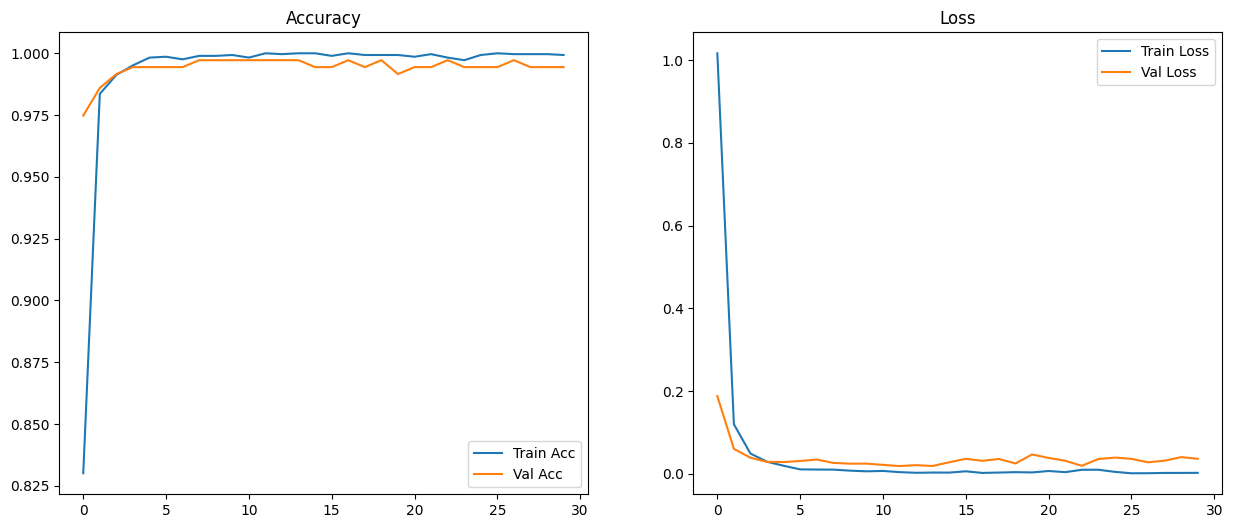

Done MobileNetV2: Accuracy=1.0000


In [4]:
## Huấn luyện TỐI ƯU mô hình: MobileNetV2
m_name = 'MobileNetV2'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: MobileNetV3
**Mô tả:** Thế hệ MobileNet mới nhất.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\4207122293.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP


--- Đang khởi tạo mô hình: MobileNetV3 ---


Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\4207122293.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\4207122293.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


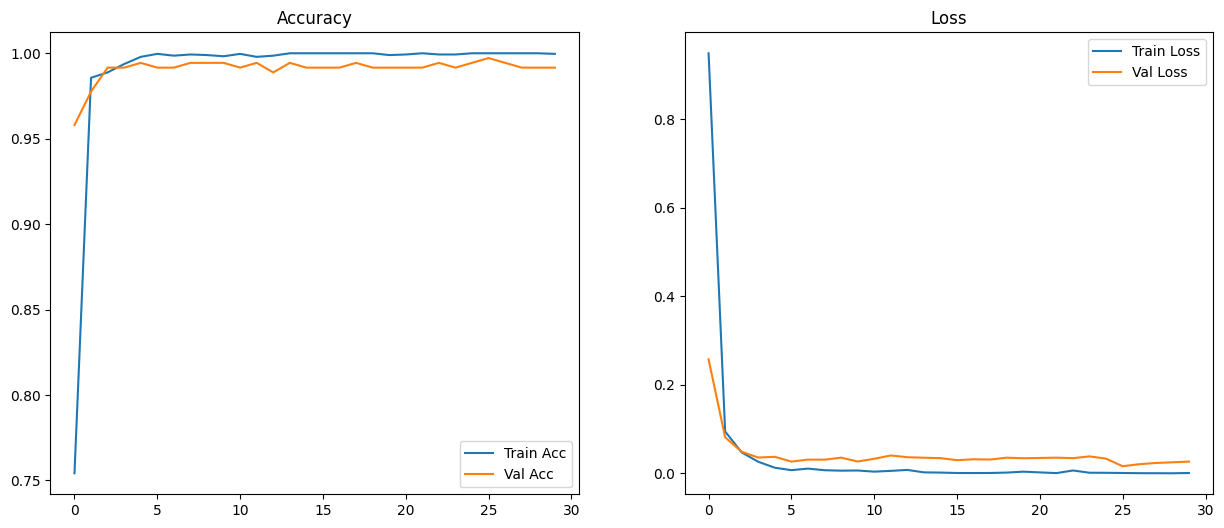

Done MobileNetV3: Accuracy=0.9972


In [5]:
## Huấn luyện TỐI ƯU mô hình: MobileNetV3
m_name = 'MobileNetV3'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ResNet18
**Mô tả:** Residual depth 18.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\533307250.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP


--- Đang khởi tạo mô hình: ResNet18 ---


Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\533307250.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\533307250.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


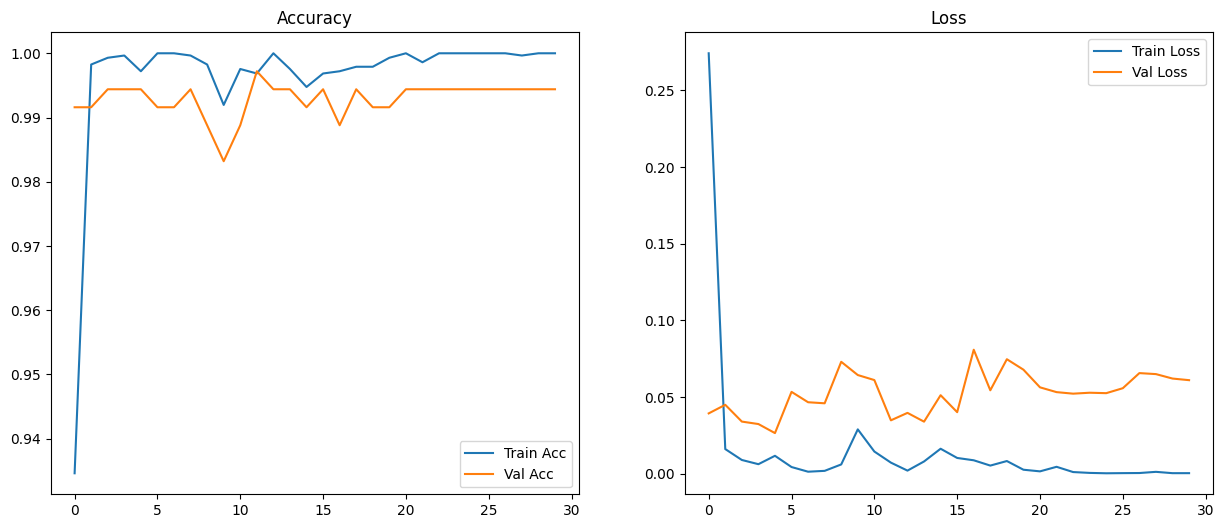

Done ResNet18: Accuracy=0.9972


In [6]:
## Huấn luyện TỐI ƯU mô hình: ResNet18
m_name = 'ResNet18'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ResNet50
**Mô tả:** Residual depth 50.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: ResNet50 ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\3181774208.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP
Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\3181774208.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\3181774208.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


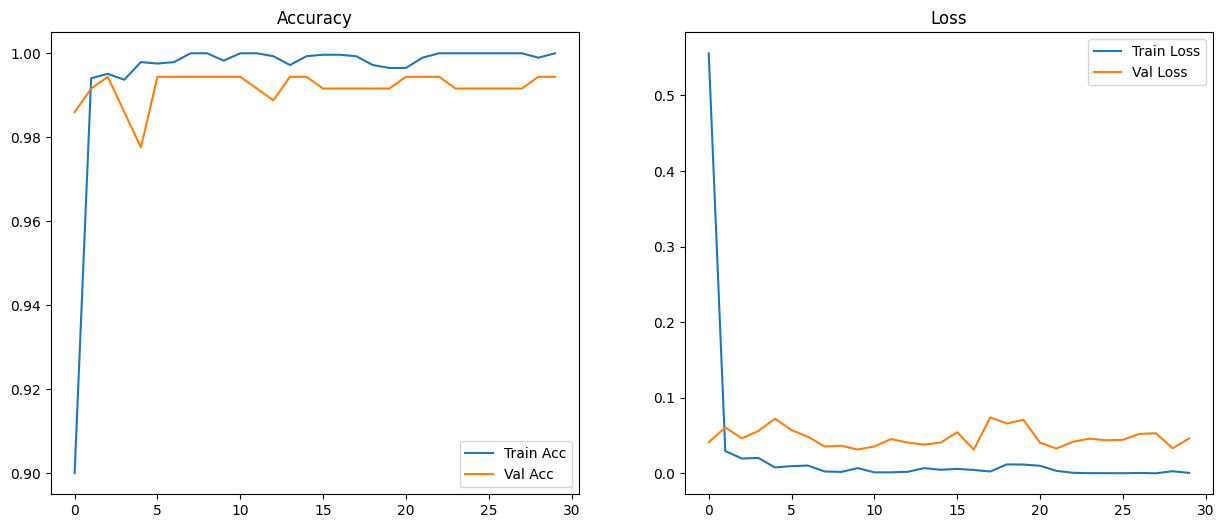

Done ResNet50: Accuracy=0.9972


In [7]:
## Huấn luyện TỐI ƯU mô hình: ResNet50
m_name = 'ResNet50'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ShuffleNetV2
**Mô tả:** Siêu nhẹ.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\3602061661.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP


--- Đang khởi tạo mô hình: ShuffleNetV2 ---


Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\3602061661.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\3602061661.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


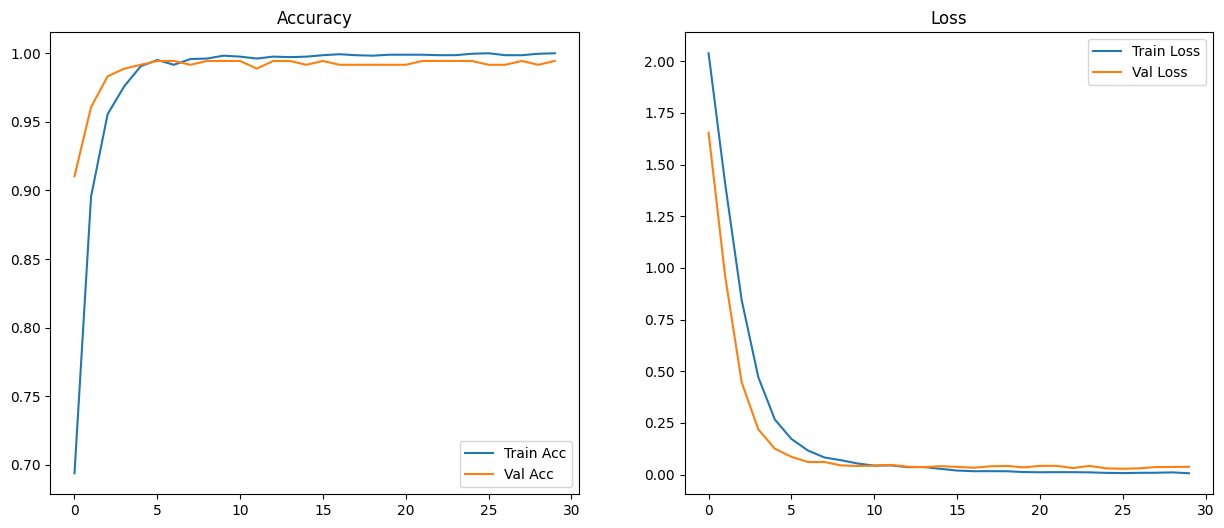

Done ShuffleNetV2: Accuracy=1.0000


In [8]:
## Huấn luyện TỐI ƯU mô hình: ShuffleNetV2
m_name = 'ShuffleNetV2'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: DenseNet121
**Mô tả:** Kết nối dày đặc.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: DenseNet121 ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\2548531891.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP
Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\2548531891.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\2548531891.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


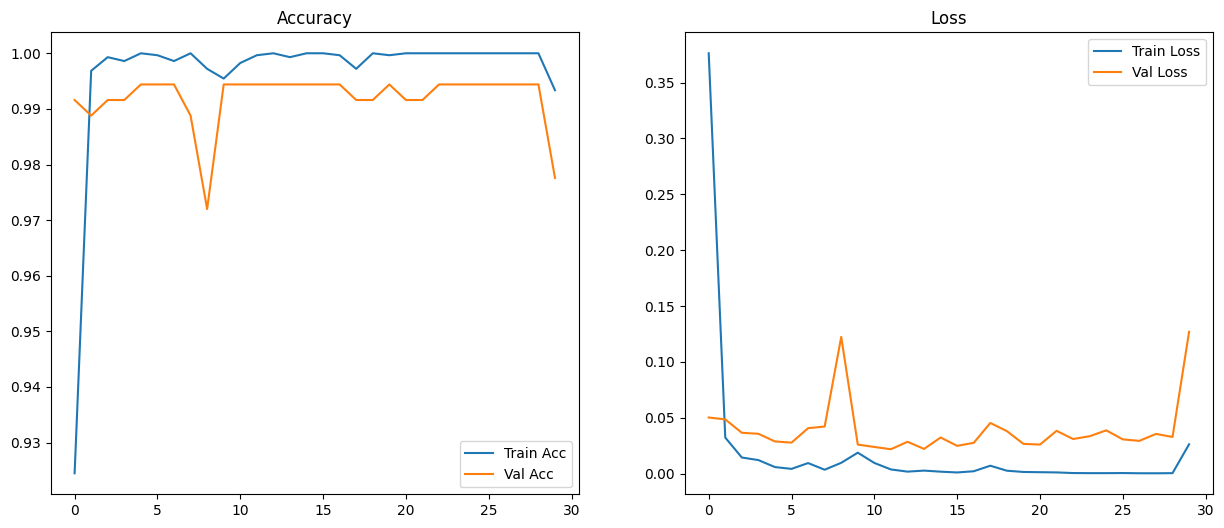

Done DenseNet121: Accuracy=0.9917


In [9]:
## Huấn luyện TỐI ƯU mô hình: DenseNet121
m_name = 'DenseNet121'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: EfficientNetV2
**Mô tả:** Tối ưu quy mô.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: EfficientNetV2 ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\1988796985.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP
Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\1988796985.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\1988796985.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


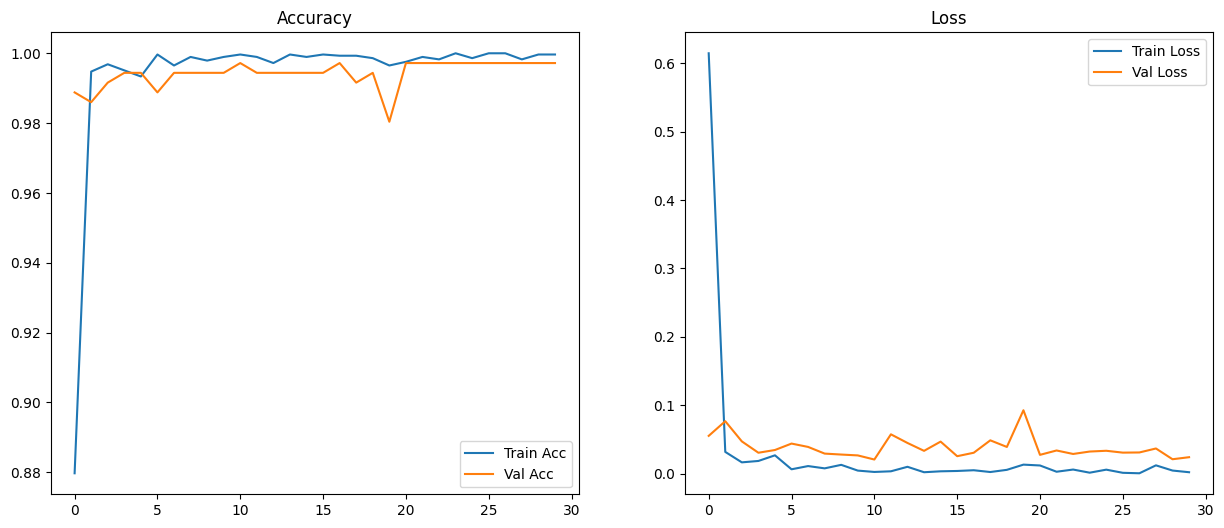

Done EfficientNetV2: Accuracy=0.9972


In [10]:
## Huấn luyện TỐI ƯU mô hình: EfficientNetV2
m_name = 'EfficientNetV2'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ConvNeXt_Tiny
**Mô tả:** Hiện đại (SOTA).

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: ConvNeXt_Tiny ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\2672192969.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # AMP
Epoch 1/30 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\2672192969.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # AMP Forward
Epoch 1/30 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_14864\2672192969.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 30/30 [Val]: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


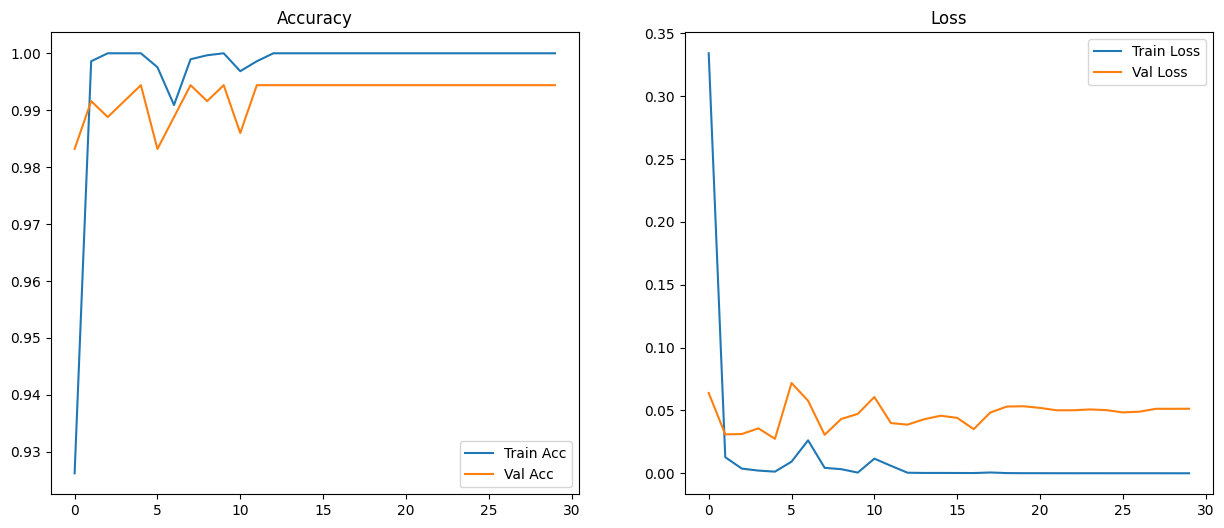

Done ConvNeXt_Tiny: Accuracy=0.9972


In [11]:
## Huấn luyện TỐI ƯU mô hình: ConvNeXt_Tiny
m_name = 'ConvNeXt_Tiny'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() # AMP

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(): # AMP Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward() # AMP Backward
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels.data).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels.data).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))

# TÍNH TOÁN METRICS
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy()); y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
mse = mean_squared_error(y_true, y_pred); rmse = np.sqrt(mse); r2 = r2_score(y_true, y_pred)

# LƯU KẾT QUẢ
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'mse': float(mse), 'rmse': float(rmse), 'r2_score': float(r2), 'accuracy': float(acc)}
with open(os.path.join(m_res_path, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)

# VẼ BIỂU ĐỒ TỔNG HỢP CHO MODEL
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc'); axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss'); axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png')); plt.show()

print(f'Done {m_name}: Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()